# Исследование и прогнозирование популярности компьютерных игр

## Описание проекта

В рамках проекта необходимо проанализировать данных из открытых источников и определить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Открытые данные представлены до 2016 года. На их основе необходимо выработать общий алгоритм оценки успешности игр.

**Цели проекта:**
1. Определить закономерности, показывающие успешность продукта.
2. Дать оценку потенциальных предпочтений клиентов в 2017 году.

**План работ:**
1. Провести предварительную подготовку данных.
2. Провести исследовательский анализ данных.
3. Определить портрет пользователя каждого региона.
4. Провести статистические тесты для сравнения игровых платформ и жанров.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

## Описание данных

Набор данных о компьютерных играх содержит следующие атрибуты:
* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

## Импорт и обзор данных

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


**Вывод:** обзор данных показывает, что данные требуют обязательной предварительной обработки.

Основные проблемы:
1. Типы данных атрибутов `year_of_release` и `user_score` не соответствуют смысловому наполнению.
2. В данных присутствуют пропуски, их необходимо исследовать детальнее.
3. Будет удобнее привести названия столбцов к нижнему регистру.


## Предварительная обработка данных

В самом начале приведем названия атрибутов к нижнему регистру:

In [6]:
data.columns = map(str.lower, data.columns)

### Приведение типов данных

Тип данных года выпуска лучше привести привести к типу int и сразу заполнить пропуски (заполнить пропуски в дате релиза вполне дрпустимо нулями, так как это не повлияет на результаты исследования):

In [7]:
data['year_of_release'] = data['year_of_release'].fillna(0).astype(int)

Проверим пропуски в столбце user_score, которые мешают преобразовать тип данных к float:

In [8]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Значение tbd (To Be Determined) значит, что рейтинг еще не назначен. Для корректности типа столбца изменим эти значения на nan. 

In [9]:
data['user_score'] =pd.to_numeric(data['user_score'], errors='coerce')

**Вывод:** типы данных во всех стобцах приведены к корректным.

### Обработка пропусков

Пропущенные значения присутствуют в атрибутах name, genre, critic_score, user_score, rating. Оценки и рейтинг обрабатывать некорректно, так как пропущенных значений много и нет возможности "предположить", какие значения там должны быть. Можно обработать вручную весь объем данных и частично собрать информацию из других источников, однако данные манипуляции не требуются в рамках данного исследования и не повлияют на его результат.

Проверим пропущенные значения в name и platform:

In [10]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Нетрудно заметить, что две записи с пропущенным name имеют также пропущенный genre и прочие атрибуты. Данные записи можно исключить из набора данных, так как информация о продажа будет неинформативна без дополнительных атрибутов.

In [11]:
data = data[~data['name'].isna()]

Рейтинг ESRB используется для простановки рейтинга в США и Канаде (т.е. NA), поэтому корректно будет заполнить пропуски значением NR (No Rating), чтобы не потерять информацию об играх без рейтинга ESRB.

In [12]:
data['rating'] = data['rating'].fillna('NR')

**Вывод:** пропущенные значения обработаны.

### Расчёт суммарных продаж по регионам

Дополнительным столбцом рассчитаем продажи по регионам:

In [13]:
data['world_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

**Вывод:** предварительная обработка набора данных завершена, типы данных приведены к требуемым, обработаны пропущенные значения, рассчитана дополнительная метрика.

In [14]:
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,' : кол-во 0', temp[temp[col_l] == 0][col_l].count(),
        ', процент 0', round(temp[temp[col_l] == 0][col_l].count()/len(temp)*100, 2),'%')
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           16713 non-null  object 
 11  world_sales      16713 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.7+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio: Instant Artist' 'wwe Smackdown vs. Raw 2006'
 '¡Shin Chan Flipa e

## Исследовательский анализ данных

### Количество выпущенных игр по годам

In [15]:
release_by_year = pd.DataFrame(data.groupby('year_of_release')['name'].count()).reset_index()
release_by_year = release_by_year[release_by_year['year_of_release'] != 0]
release_by_year.columns = ['year', 'num_of_games']

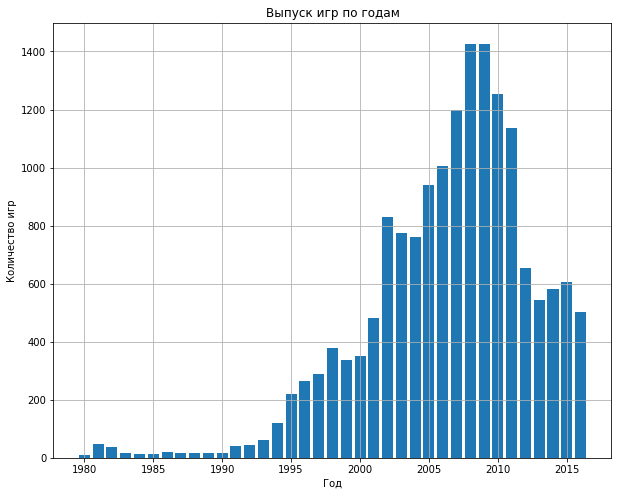

In [16]:
plt.figure(figsize=(10,8));
plt.bar(release_by_year['year'], release_by_year['num_of_games']);
plt.grid(True);
plt.title('Выпуск игр по годам');
plt.xlabel('Год');
plt.ylabel('Количество игр');

**Вывод:** заметный рост количества выпущенных игр начался после 1990-х годов. Также всплески были в 1995 году и в 2002 году. Пиковые значения располагаются в 2008 и 2009 году, в эти годы выпускалось больше всего игр, после чего начался спад. Спад с 2010 года можно связать с тем, что качество игр значительно выросло и процесс производства стал более трудоемким и долгим. Таким образом четко прослеживается развития производства игр. Сначала период развития, потом период "количества", затем период качества и некоторая стагнация. **В качестве актуального периода для данного исследования можно предварительно закрепить 2012-2016 год**, так как в этот период уже нет существенных изменений по количеству выпущенных игр.

### Динамика продаж по платформам

In [17]:
sales_by_platform = data[data['year_of_release'] != 0].groupby(['platform', 'year_of_release'])['world_sales'].sum().reset_index()
sales_by_platform.columns = ['platform', 'year', 'sales']

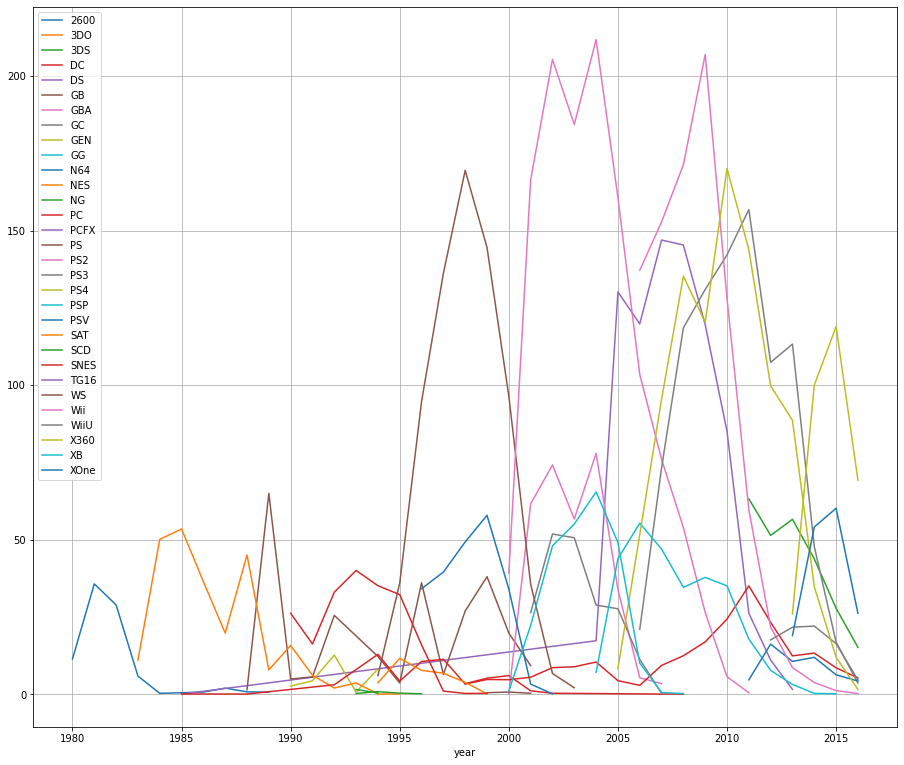

In [18]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_axes([0,0,1,1])
for p in sales_by_platform.platform.unique():
    sales_by_platform[sales_by_platform['platform'] == p].plot(x='year', y='sales', ax=ax, label=p)
plt.grid()

Обилие платформ усложняет визуальную оценку продаж с разных платформ по годам, поэтому, необходимо выделить лидеров по продажам для более детального анализа. Однако, стоит заметить, что высокие продажи относительно каждой платформы занимают период суммарно около 5 лет, далее идут либо незначительные продажи (если смотреть в будущее), либо только самое зарождение платформы (если смотреть в прошлое). Также можно заметить, что в данных присутствуют ошибки, которые не влияют на результаты исследования, однако о них стоит сказать. Например, платформа DS, которая была выпущена только в 2004 году, имеет информацию о продажах и до этого года.

Выделим 5 лидеров по суммарным продажам и посмотрим их динамику по годам:

In [19]:
sales_by_platform_agg = pd.DataFrame(sales_by_platform.groupby('platform')['sales'].sum()).reset_index()
top_5_platform = sales_by_platform_agg.sort_values(by='sales', ascending=False).head(5)['platform']
sales_by_platform_agg.sort_values(by='sales', ascending=False).head(5)

,platform,sales
16,PS2,1233.56
28,X360,961.24
17,PS3,931.34
26,Wii,891.18
4,DS,802.78


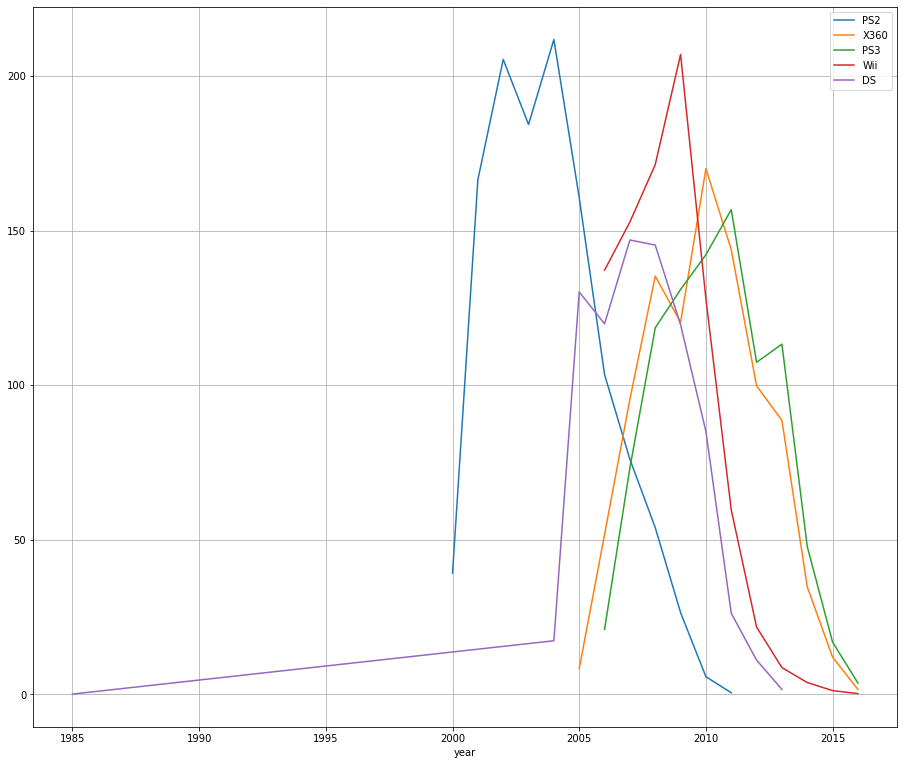

In [20]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_axes([0,0,1,1])
for p in top_5_platform:
    sales_by_platform[sales_by_platform['platform'] == p].plot(x='year', y='sales', ax=ax, label=p)
plt.grid()

**Вывод:** нетрудно заметить, что основные продажи идут с платформ от Sony (серия PS) и Microsoft (серия XBox). В дальнейшем следует ориентироваться именно на эти платформы. Остальные платформы имеют локальные всплески и не имеют продолжения серий (например, Nintendo Wii/DS)

### Формализация данных для исследования 2017 года

Как уже было обозначено ранее, для 2017 года целесообразно рассматривать исторический период, когда количество выпущенных игр условно стагнирует, т.е. период, начиная с 2012 года.

С точки зрения платформ, целесообразно рассматривать исторический период, когда появились в продаже самые "топовые" платформы от Microsoft и Sony, т.е. начиная с 2013 года (однако, по всему миру платформы начали продаваться с 2014 года). Таким образом в качестве актуального установим период с **2014 по 2016 год включительно**.

Приоритетными для прогноза в 2017 году установим платформы серии PS и XBOX, т.е. PS4 и Xbox One.

In [21]:
min_date = 2014

### Анализ самых перспективных платформ

In [22]:
top_2_platform = ['XOne', 'PS4']
data_top = data.query('platform.isin(@top_2_platform) and year_of_release >= @min_date')

#### Анализ диаграмм размаха

Построим диаграммы размаха для топовых платформ и для всех платформ для сравнения.

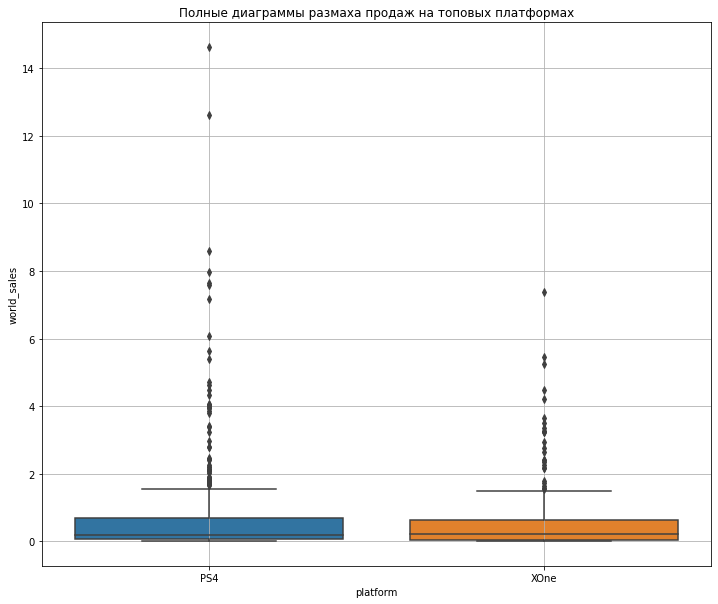

In [23]:
plt.figure(figsize=(12,10));
sns.boxplot(x='platform', y='world_sales', data=data_top);
plt.grid();
plt.title('Полные диаграммы размаха продаж на топовых платформах');

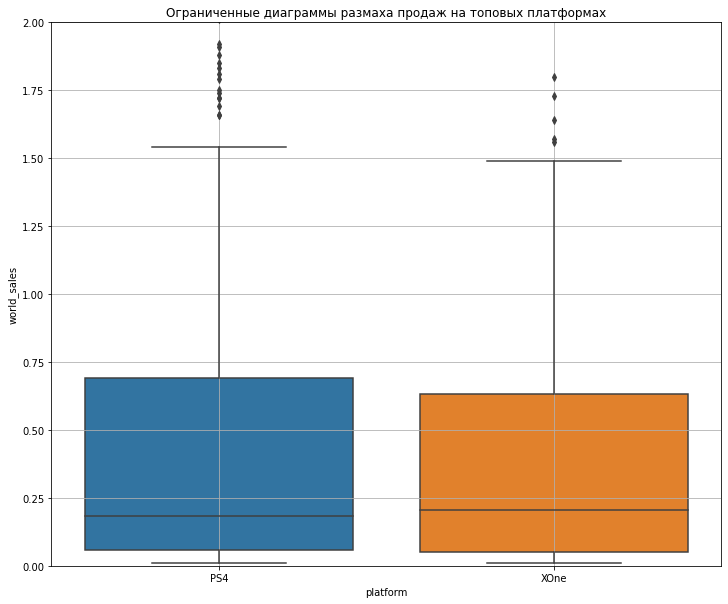

In [24]:
plt.figure(figsize=(12,10));
sns.boxplot(x='platform', y='world_sales', data=data_top);
plt.grid();
plt.title('Ограниченные диаграммы размаха продаж на топовых платформах');
plt.ylim((0,2));

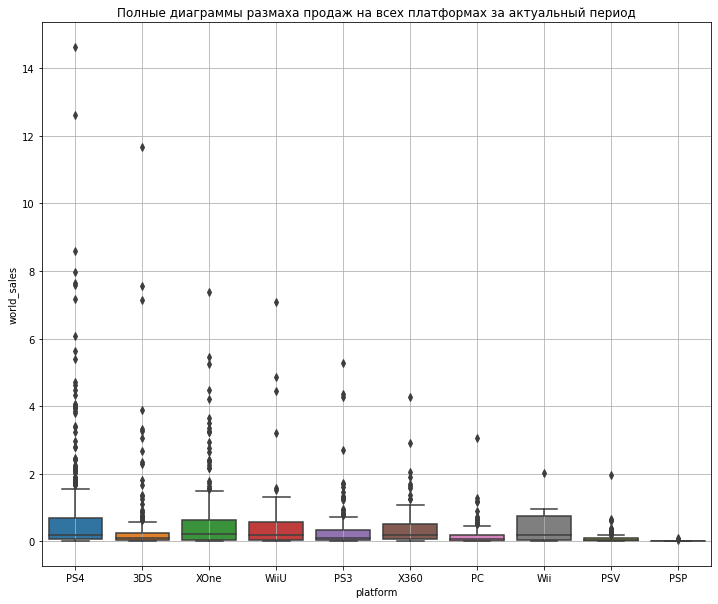

In [25]:
plt.figure(figsize=(12,10))
sns.boxplot(x='platform', y='world_sales', data=data[data.year_of_release >= min_date]);
plt.grid();
plt.title('Полные диаграммы размаха продаж на всех платформах за актуальный период');

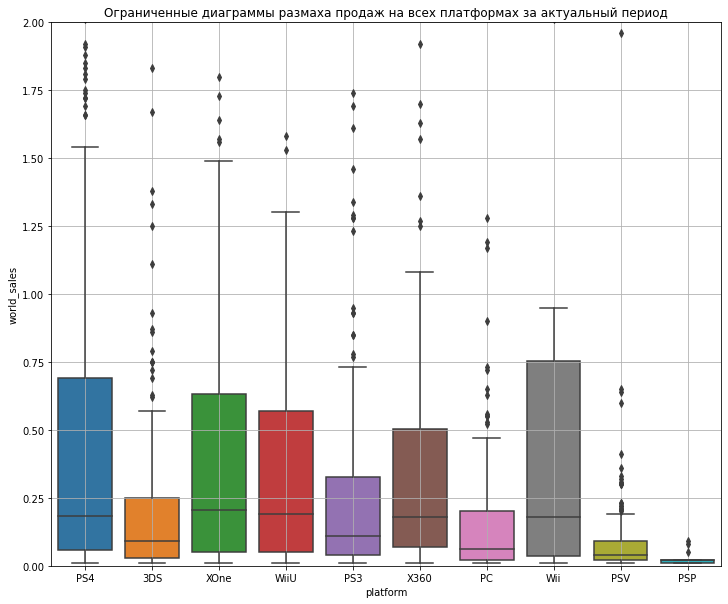

In [26]:
plt.figure(figsize=(12,10))
sns.boxplot(x='platform', y='world_sales', data=data[data.year_of_release >= min_date]);
plt.grid();
plt.title('Ограниченные диаграммы размаха продаж на всех платформах за актуальный период');
plt.ylim((0,2));

**Вывод**: легко увидеть, что продажи почти по всем платформам, в том числе, по топовым неоднородны. Во всех случаях есть игры, которые приносят большое количество продаж, а есть "проходные" варианты.

#### Корреляция между рейтингами и продажами

Выделим топ 5 актуальных платформ в актуальном периоде и проанализируем влияние рейтингов на продажи.

In [27]:
data[data.year_of_release >= min_date].groupby('platform')['world_sales'].sum().sort_values(ascending=False).head()

platform
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
Name: world_sales, dtype: float64

In [28]:
top5_platf = ['PS4', 'XOne', '3DS', 'PS3', 'X360']

In [29]:
data_top_platform = data.query('platform.isin(@top5_platf) and year_of_release >= @min_date').drop(columns=['name', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'rating'])

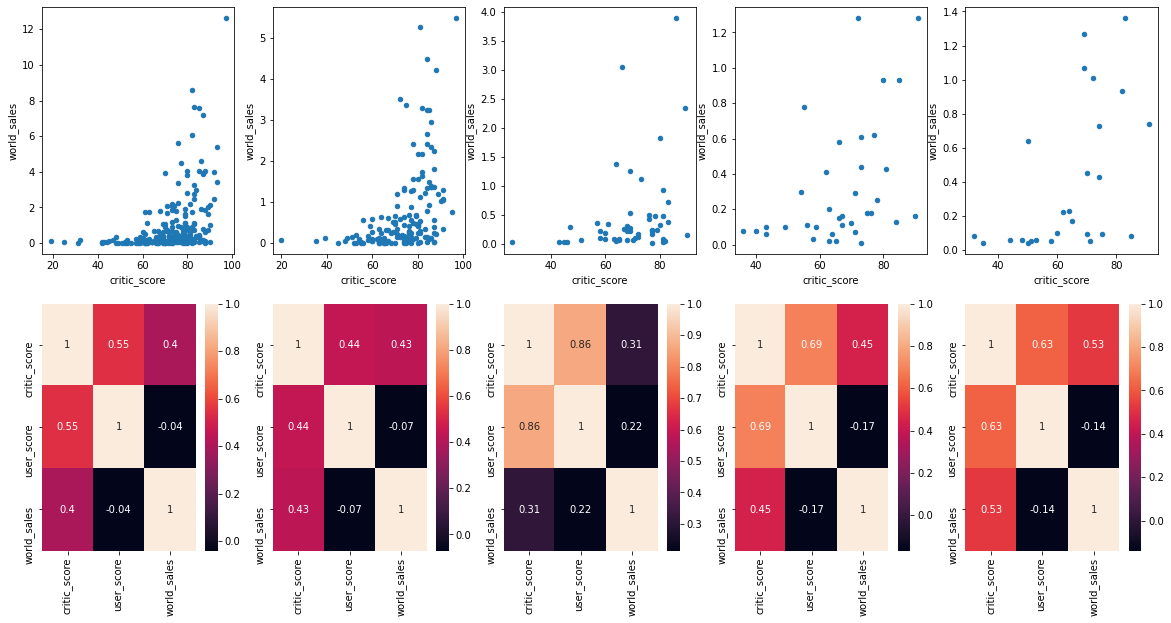

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
for pl, i in zip(top5_platf, range(len(top5_platf))):
    data_top_platform[data_top_platform.platform==pl].plot('critic_score', 'world_sales', kind='scatter', ax = axes[0, i]);
    sns.heatmap(data_top_platform[data_top_platform.platform==pl].corr(), annot=True, ax=axes[1, i]);





Нетрудно заметить, что в обоих случаях, выбросы очень сильно влияют на результат и считать корреляции в таких случаях будет некорректно. Однако, уже даже без фильтрации данных видна прямая корреляция между оценками критиков и оценками пользователей.

Для корректного расчёта коэффициентов корреляции Пирсона отфильтруем данные по каждой платформе:

In [33]:
data_top_ps_filtered = data_top_platform.query('platform == "PS4" and world_sales < 1.8')
data_top_xbox_filtered = data_top_platform.query('platform == "XOne" and world_sales < 1.8')

Построим матрицы корреляций для отфильтрованных данных на 2 топовых платформах:

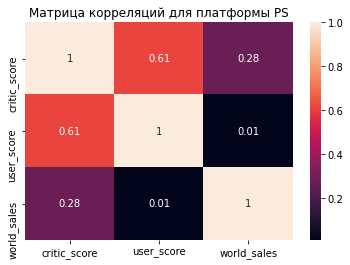

In [34]:
sns.heatmap(data_top_ps_filtered.corr(), annot=True);
plt.title('Матрица корреляций для платформы PS');

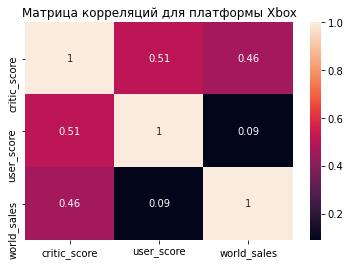

In [35]:
sns.heatmap(data_top_xbox_filtered.corr(), annot=True);
plt.title('Матрица корреляций для платформы Xbox');

**Вывод**: 

1. Как было замечено ранее, есть достаточно сильная корреляция между оценками пользователей и критиков (0.61 для PS, 0.51 для Xbox).
2. Практически отсутствует корреляция между мировыми продажами и оценками пользователей для обоих платформ.
3. Присутствует несильная положительная корреляция (0.46) между оценками критиков и продажами для платформы Xbox и довольная слабая положительная корреляция (0.28) для платформы PS.

Таким образом, можно заключить, что высокие оценки критиков скорее способны увеличить продажи, однако нельзя устанавливать причинно-следственные связи, между этими событиями. При этом важно понимать, что установленные корреляции актуальны только для игр, продажи которых не рекордно высокие. В случаях, когда игры приносят много продаж, также будут аналогичные корреляции, хотя опять же нужно делать акцент на том, что это не причинно-следственные связи. Вероятнее всего, эти переменные связывают между собой относительно субъективные факторы, такие как интерес прохождения игры, графика, сюжет, проведение маркетинговых компаний и т.п. Аналогичные выводы можно сделать и для остальных платформ, т.е. оценки и продажи связаны через промежуточные переменные. 

Если отвлечься от полученных выводов, можно сделать заключение, что вышеуказанные результаты абсолютно логичны, то есть присутствует связка: (интерес к игре) -> выше продажи и выше оценки. Таким образом, при анализе перспективных игр, нужно учитывать не только продажи и оценки предыдущих лет, но и динамику развития отдельно выбранных игр в наблюдаемом году. Чуть меньше внимания нужно к уже "раскрученным" играм и студиям, игры которых с большой вероятностью будут популярны.

Опять же, стоит обратить внимание на то, что хоть и присутствуют положительные корреляции между оценками и продажами, ситуация может сложиться ровно противоположной, т.е. игра, у которой будут очень высокие продажи (известная серия/студия и.т.п) окажется провальной с точки зрения оценок, что в дальнейшем будет уменьшать продажи у следующих игр серии/студии.

Основной вывод заключается в том, что нужно учитывать не только платформу, оценку и продажи в прошлом, но и брать в рассмотрение новости о каждой отдельной выпускающей компании или игре.

### Продажи игр по жанрам

Построим суммарные и медианные продажи в каждом жанре по годам:

Для начала, посмотрим на суммарные продажи:

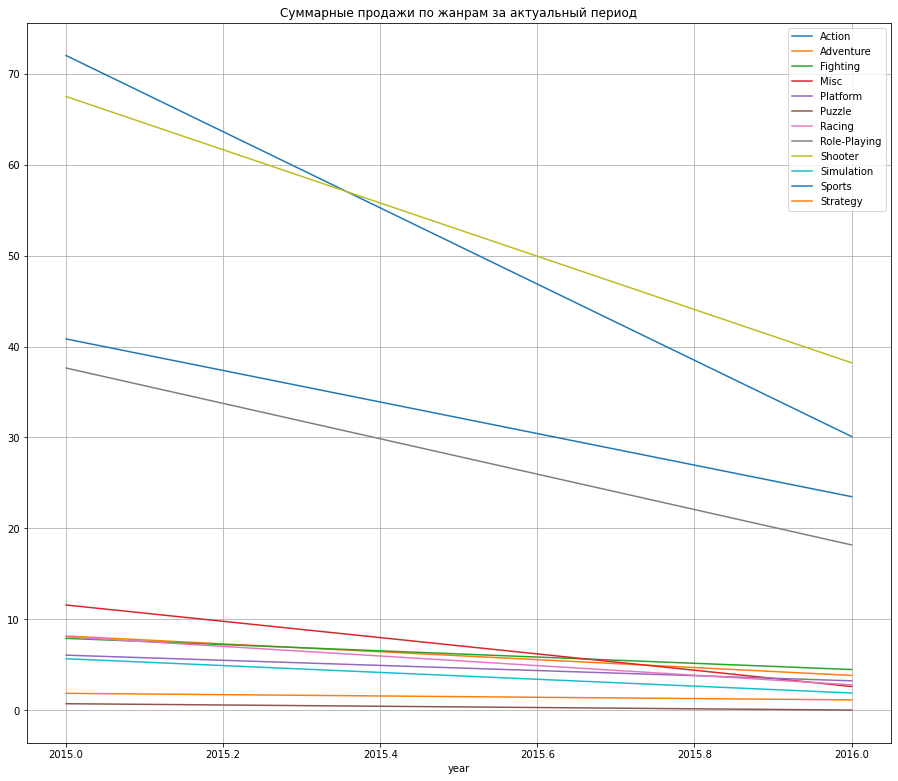

In [36]:
genres_sales_by_year = data.groupby(['genre', 'year_of_release'])['world_sales'].sum().reset_index()
genres_sales_by_year = genres_sales_by_year[genres_sales_by_year['year_of_release'] > min_date]
genres_sales_by_year.columns = ['genre', 'year', 'sales']
fig = plt.figure(figsize=(12,10))
ax = fig.add_axes([0,0,1,1])
for p in genres_sales_by_year.genre.unique():
    genres_sales_by_year[genres_sales_by_year['genre'] == p].plot(x='year', y='sales', ax=ax, label=p)
plt.grid()
plt.title('Суммарные продажи по жанрам за актуальный период');

Далее, изучим медианные продажи:

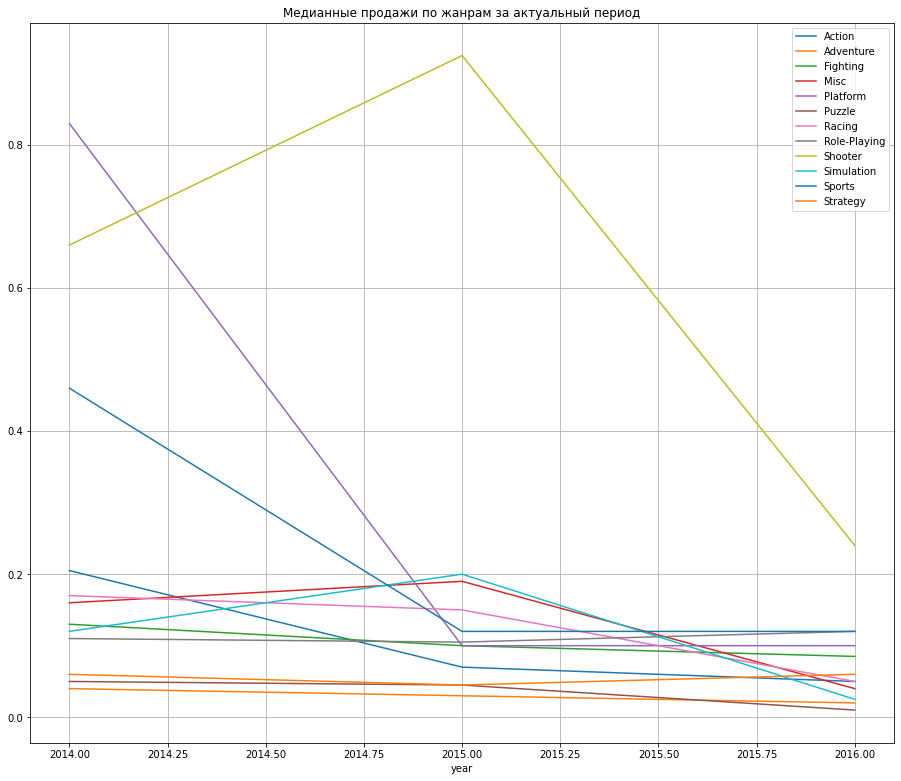

In [37]:
genres_sales_by_year = data.groupby(['genre', 'year_of_release'])['world_sales'].median().reset_index()
genres_sales_by_year = genres_sales_by_year[genres_sales_by_year['year_of_release'] >= min_date]
genres_sales_by_year.columns = ['genre', 'year', 'sales']
fig = plt.figure(figsize=(12,10))
ax = fig.add_axes([0,0,1,1])
for p in genres_sales_by_year.genre.unique():
    genres_sales_by_year[genres_sales_by_year['genre'] == p].plot(x='year', y='sales', ax=ax, label=p)
plt.grid()
plt.title('Медианные продажи по жанрам за актуальный период');

Добавим полную и усеченную диаграмму размаха для 2016 года:

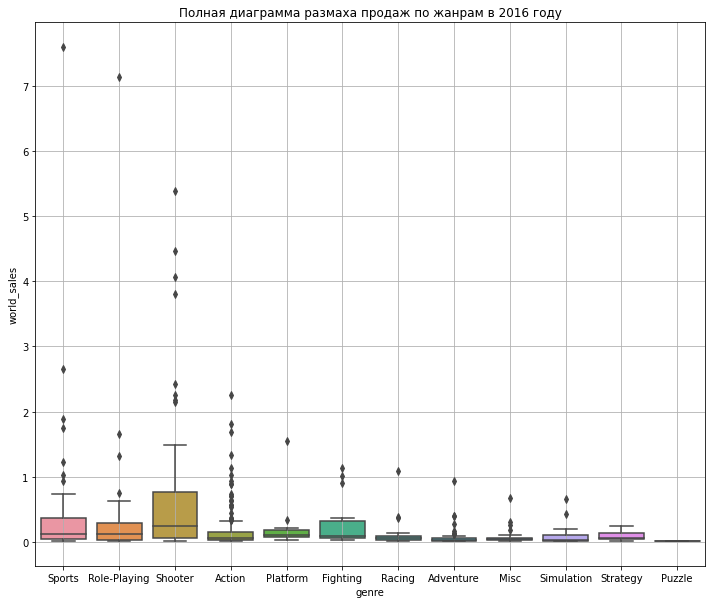

In [38]:
plt.figure(figsize=(12,10));
sns.boxplot(x='genre', y='world_sales', data=data[data.year_of_release == 2016]);
plt.grid();
plt.title('Полная диаграмма размаха продаж по жанрам в 2016 году');


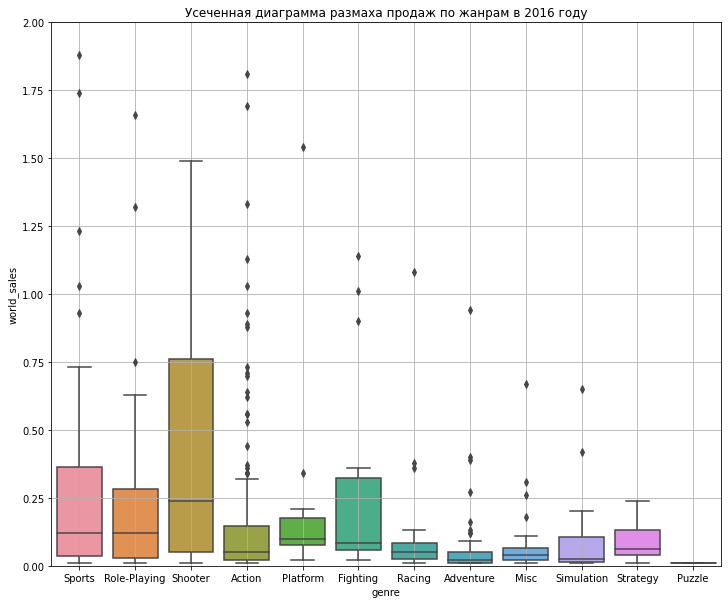

In [39]:
plt.figure(figsize=(12,10));
sns.boxplot(x='genre', y='world_sales', data=data[data.year_of_release == 2016]);
plt.grid();
plt.title('Усеченная диаграмма размаха продаж по жанрам в 2016 году');
plt.ylim((0,2));

**Вывод**: 

Если смотреть на суммарные продажи, то важно отметить, что самые продаваемые жанры меняются от года к году. Например, в 1990 году самый продаваемый жанр - Platform, в 2005 году - Action, а в 2016 году - Shooter.

Можно выделить явных лидеров и явных аутсайдеров. 

В лидерах: 
* Action 
* Shooter 
* Sport 

В аутсайдерах: 
* Puzzle
* Strategy

Остальные жанры имеют переменный успех от года к году.

Важно заметить, что смена продаваемых жанров связана во многом с общей тенденцией к "упрощению" игр. То есть с течением лет пользователей всё больше и больше интересуют более простые и короткие (с точки зрения длительности одной игровой сессии) игры.

Если посмотреть на медианные продажи, то картина немного меняется:

Оказывается, что стабильно лучше всех продаются всё так же игры в жанре Shooter, а вот высокие суммарные продажи остальных жанров связаны с отдельными "хитами" в жанрах (медианные продажи условно стабильны).

Также стоит отметить тот факт, что продажи игр в жанре Shooter в 2016 году не имеют аномальных выбросов, что можно трактовать, как общую успешность жанра.

## Портреты пользователей регионов

In [40]:
data_port = data[data['year_of_release'] >= min_date]

In [41]:
# определим функцию для автоматизации анализа
def region_analysis(df, region, group, color='blue'):
    df_gr = df.groupby(group)[region].sum().reset_index().sort_values(by=region, ascending=False).head()
    df_gr.plot.bar(x = group, y = region, color=color)
    display(df_gr)
    if region == 'na_sales':
        text_gr = 'Северной Америке'
    elif region == 'eu_sales':
        text_gr = 'Европе'
    elif region == 'jp_sales':
        text_gr = 'Японии'
    else:
        text_gr = 'регионе'
        
    if group == 'platform':
        text_gr2 = 'платформ'
    elif group == 'genre':
        text_gr2 = 'жанров'
    elif group == 'rating':
        text_gr2 = 'рейтингов'
    else:
        text_gr2 = ''
    plt.title(f'Топ 5 {text_gr2} по продажам в {text_gr}')
    plt.ylabel('Продажи')
    plt.grid()

### Платформы по регионам

,platform,na_sales
3,PS4,98.61
9,XOne,81.27
8,X360,28.30
0,3DS,22.64
2,PS3,22.05


,platform,eu_sales
3,PS4,130.04
9,XOne,46.25
2,PS3,25.54
1,PC,17.97
0,3DS,16.12


,platform,jp_sales
0,3DS,44.24
3,PS4,15.02
5,PSV,14.54
2,PS3,11.22
7,WiiU,7.31


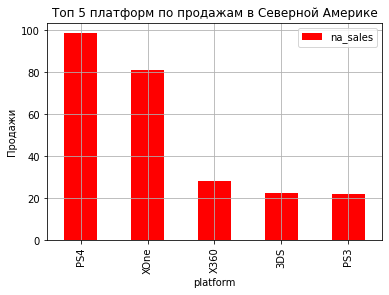

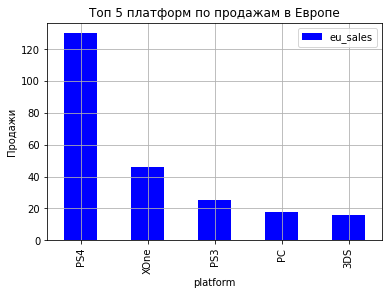

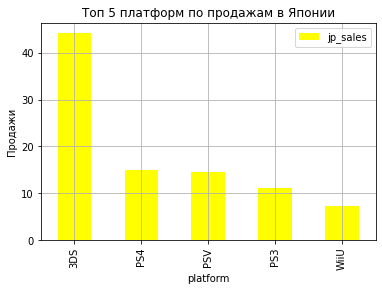

In [42]:
region_analysis(data_port, 'na_sales', 'platform', 'red')
region_analysis(data_port, 'eu_sales', 'platform', 'blue')
region_analysis(data_port, 'jp_sales', 'platform', 'yellow')

**Вывод:** 
1. По сравнению с Европой и Америкой, в Японии продажи в целом ниже более чем в 2 раза, что можно объяснить размерами региона. В таком случае более корректно сравнивать не продажи, а продажи на количество человек, такие данные будут более показательными.
2. Самая распространенная платформа в Америке и Европе - PS4, в Японии - 3DS.
3. Интересным фактом является то, что в Европе количество PS4 подавляющее, в то время, как в Америке PS4 и Xbox One располагаются довольно близко по продажам.
4. В Японии мало продаж консолей от Microsoft (Xbox), они не входят в топ-5, при этом топ-5 платформ, за исключением 3DS, продаются практически на одном уровне.
5. Америка предпочитает приставки стационарным компьютерам, PC не входят топ-5 в Америке, в отличие от Европы.

### Жанры по регионам

In [44]:
genre_group = data_port.groupby('genre')[['na_sales', 'eu_sales', 'jp_sales']].sum().reset_index()
top_genre_na = genre_group.sort_values('na_sales', ascending=False).head()['genre']
top_genre_eu = genre_group.sort_values('eu_sales', ascending=False).head()['genre']
top_genre_jp = genre_group.sort_values('jp_sales', ascending=False).head()['genre']

genre_group_na = genre_group[['genre', 'na_sales']].copy()
genre_group_na.loc[~genre_group_na.genre.isin(top_genre_na), 'genre'] = 'other'
genre_group_na_fin = genre_group_na.groupby('genre').sum().reset_index()

genre_group_eu = genre_group[['genre', 'eu_sales']].copy()
genre_group_eu.loc[~genre_group_eu.genre.isin(top_genre_eu), 'genre'] = 'other'
genre_group_eu_fin = genre_group_eu.groupby('genre').sum().reset_index()

genre_group_jp = genre_group[['genre', 'jp_sales']].copy()
genre_group_jp.loc[~genre_group_jp.genre.isin(top_genre_jp), 'genre'] = 'other'
genre_group_jp_fin = genre_group_jp.groupby('genre').sum().reset_index()


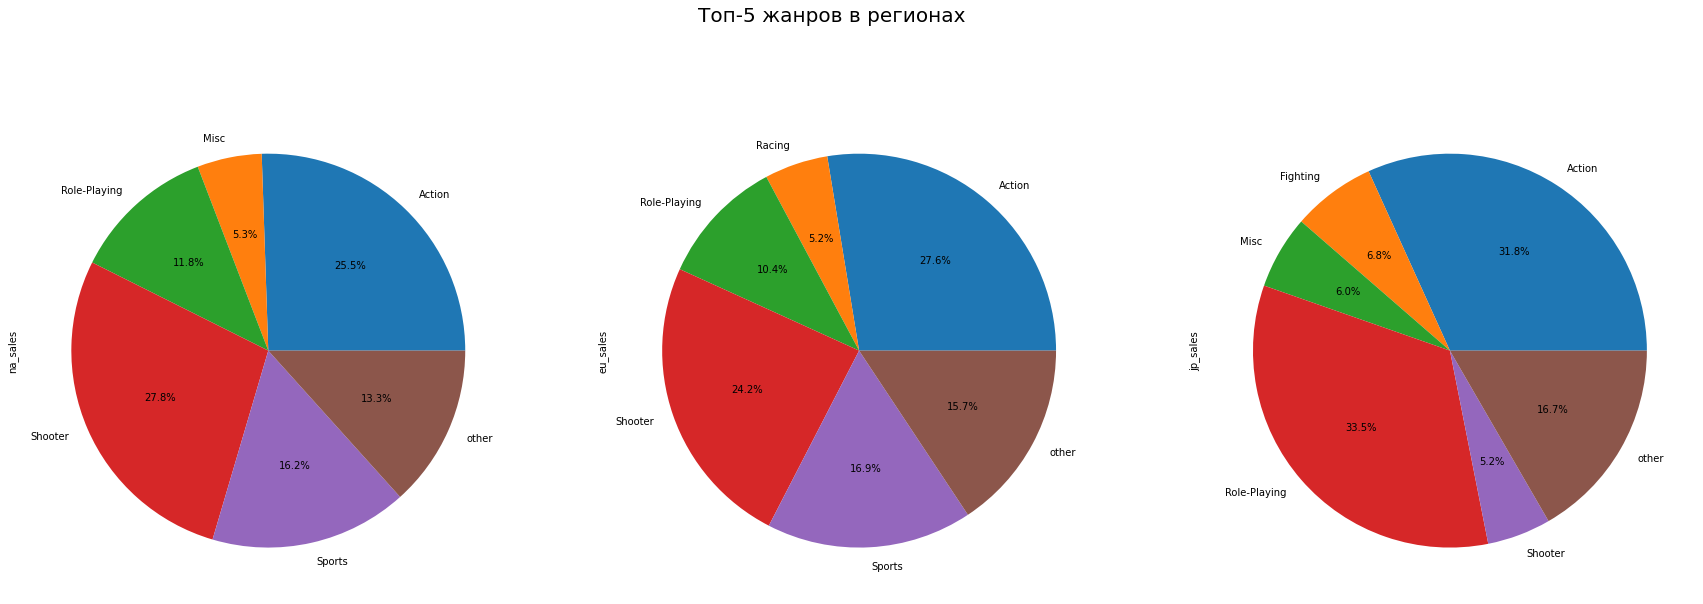

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10));
fig.suptitle('Топ-5 жанров в регионах', fontsize=20)
genre_group_na_fin.set_index('genre').plot(kind='pie', 
                                           x='genre', y='na_sales', 
                                           autopct='%1.1f%%', legend=False,
                                           ax=axes[0]);
genre_group_eu_fin.set_index('genre').plot(kind='pie', 
                                           x='genre', y='eu_sales', 
                                           autopct='%1.1f%%', legend=False,
                                           ax=axes[1]);
genre_group_jp_fin.set_index('genre').plot(kind='pie', 
                                           x='genre', y='jp_sales', 
                                           autopct='%1.1f%%', legend=False,
                                           ax=axes[2]);


**Вывод:**
1. Предпочтения Японии принципиально отличаются от предпочтений Америки и Европы.
2. Жанры Action, Shooter и RPG во всех регионах входят в топ-5.
3. Во многом предпочтения в жанрах зависят от культурных особенностей регионов.
4. Продажи в Японии значительно ниже, чем в Европе и Америке (что аналогично легко объясняется размерами регионов).
5. Самый продаваемый жанр в Америке - Shooter, в Европе - Action, в Японии - RPG.

### Возрастной рейтинг по регионам

,rating,na_sales
2,M,96.42
3,NR,64.72
0,E,50.74
4,T,38.95
1,E10+,33.23


,rating,eu_sales
2,M,93.44
3,NR,58.95
0,E,58.06
4,T,34.07
1,E10+,26.16


,rating,jp_sales
3,NR,56.90
4,T,14.78
0,E,8.94
2,M,8.01
1,E10+,4.46


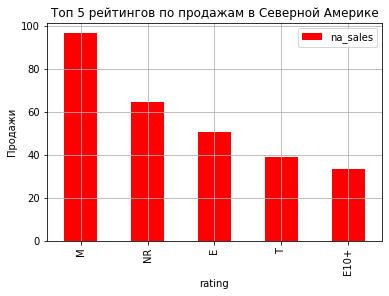

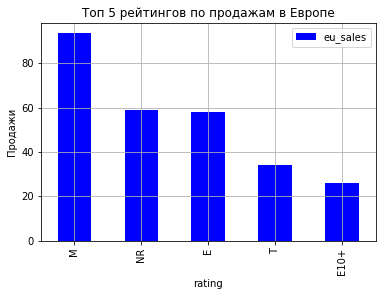

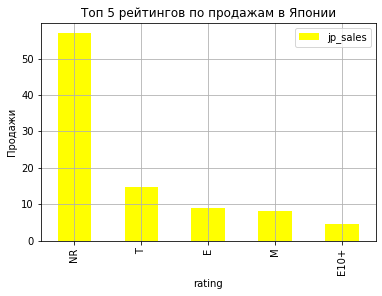

In [46]:
region_analysis(data_port, 'na_sales', 'rating', 'red')
region_analysis(data_port, 'eu_sales', 'rating', 'blue')
region_analysis(data_port, 'jp_sales', 'rating', 'yellow')

In [47]:
temp = data[data['year_of_release'] >= min_date].copy()
print(temp.rating.isna().sum(), temp.rating.isna().sum()/len(temp))
temp.rating.value_counts()

0 0.0


NR      749
T       271
M       265
E       219
E10+    185
Name: rating, dtype: int64

Расшифоровка рейтингов:
* **E** - everyone, т.е. для всех
* **E10+** - everyone 10+, т.е. для всех старше 10 лет
* **T** - teen, т.е. для возрастной категории 13-19 лет
* **M** - mature, т.е. для всех старше 17 лет
* **NR** - no rating, т.е. нет рейтинга по системе ESRB

**Вывод**: 
1. В Америке и Европе наиболее распространены игры для взрослых, в Японии - игры, которые не оцениваются системой ESRB.
2. Порядок рейтингов в Европе и Америке идентичные.
3. Игры для взрослых не очень популярны в Японии. Косвенно это можно связать с культурными особенностями, а также можно обратить внимание на приоритетные игровые платформы. На серию Xbox и PS гораздо больше игр с возрастным ограничеем "для взрослых", но данные платформы в Японии продаются гораздо хуже, чем в других регионах.

## Проверка гипотез

Так как исследование не является высокоточным, назначим уровень значимости равный 0.05.

In [48]:
alpha = 0.05

### Гипотеза о равенстве средних пользовательских рейтингов платформ Xbox One и PC

Подготовка выборок:

In [49]:
xbox_score = data.query('platform == "XOne" and year_of_release >= @min_date')
xbox_score = xbox_score.loc[~xbox_score.user_score.isna(), 'user_score']
pc_score = data.query('platform == "PC" and year_of_release >= @min_date')
pc_score = pc_score.loc[~pc_score.user_score.isna(), 'user_score']

Смотрим на распределения:

Средняя оценка пользователей PC: 6.59 
Дисперсия выборки: 1.88 
Стандартное отклонение выборки: 1.37


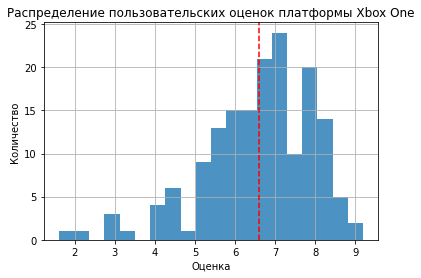

In [50]:
xbox_score.hist(bins=20, alpha = 0.8);
plt.title('Распределение пользовательских оценок платформы Xbox One');
plt.xlabel('Оценка');
plt.ylabel('Количество');
plt.axvline(xbox_score.mean(), linestyle='--', color='red');
print(f'Средняя оценка пользователей PC: {round(xbox_score.mean(), 2)} \nДисперсия выборки: {round(np.var(xbox_score), 2)} \nСтандартное отклонение выборки: {round(np.std(xbox_score), 2)}')

Средняя оценка пользователей PC: 6.3 
Дисперсия выборки: 2.88 
Стандартное отклонение выборки: 1.7


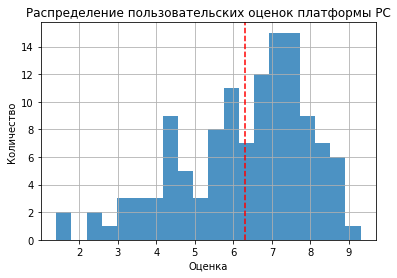

In [51]:
pc_score.hist(bins=20, alpha = 0.8);
plt.title('Распределение пользовательских оценок платформы PC');
plt.xlabel('Оценка');
plt.ylabel('Количество');
plt.axvline(pc_score.mean(), linestyle='--', color='red');
print(f'Средняя оценка пользователей PC: {round(pc_score.mean(), 2)} \nДисперсия выборки: {round(np.var(pc_score), 2)} \nСтандартное отклонение выборки: {round(np.std(pc_score), 2)}')

Постановка гипотез:
* H0 - средние пользовательские оценки платформ PC и Xbox One равны
* H1 - средние пользовательские оценки платформ PC и Xbox One различны

Метод проверки: t-test Стьюдента (считаем дисперсии генеральных совокупностей равными, т.к. нет оснований считать обратное), т.к. нам нужно верифицировать равенство средних генеральных совокупностей пользователей PC и XBox One.

In [52]:
results = st.ttest_ind(
    pc_score, 
    xbox_score)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу о равестве ")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


**Вывод:** не получилось отвергнуть нулевую гипотезу о равенстве средних пользовательских рейтингов платформ Xbox One и PC.

### Гипотеза о равенстве средних пользовательских рейтингов жанров Action и Sports 

In [53]:
action_score = data.query('genre == "Action" and year_of_release >= @min_date')
action_score = action_score.loc[~action_score.user_score.isna(), 'user_score']
sport_score = data.query('genre == "Sports" and year_of_release >= @min_date')
sport_score = sport_score.loc[~sport_score.user_score.isna(), 'user_score']

Средняя оценка пользователей PC: 6.76 
Дисперсия выборки: 1.89 
Стандартное отклонение выборки: 1.38


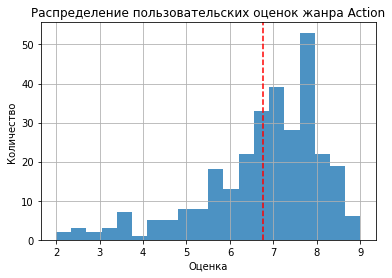

In [54]:
action_score.hist(bins=20, alpha = 0.8);
plt.title('Распределение пользовательских оценок жанра Action');
plt.xlabel('Оценка');
plt.ylabel('Количество');
plt.axvline(action_score.mean(), linestyle='--', color='red');
print(f'Средняя оценка пользователей PC: {round(action_score.mean(), 2)} \nДисперсия выборки: {round(np.var(action_score), 2)} \nСтандартное отклонение выборки: {round(np.std(action_score), 2)}')

Средняя оценка пользователей PC: 5.23 
Дисперсия выборки: 3.42 
Стандартное отклонение выборки: 1.85


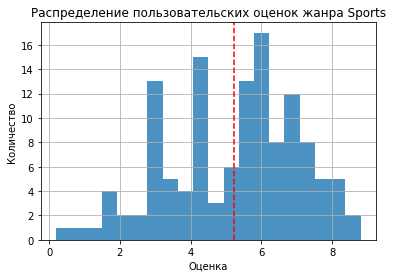

In [55]:
sport_score.hist(bins=20, alpha = 0.8);
plt.title('Распределение пользовательских оценок жанра Sports');
plt.xlabel('Оценка');
plt.ylabel('Количество');
plt.axvline(sport_score.mean(), linestyle='--', color='red');
print(f'Средняя оценка пользователей PC: {round(sport_score.mean(), 2)} \nДисперсия выборки: {round(np.var(sport_score), 2)} \nСтандартное отклонение выборки: {round(np.std(sport_score), 2)}')

Постановка гипотез:
* H0 - средние пользовательские оценки жанров Action и Sports равны
* H1 - средние пользовательские оценки жанров Action и Sports различны

Метод проверки: t-test Стьюдента (считаем дисперсии генеральных совокупностей различными, т.к. предпочтения людей в разных видах спорта могут быть неоднородны), т.к. нам нужно верифицировать равенство средних генеральных совокупностей жанров Action и Sports.

In [56]:
results = st.ttest_ind(
    action_score, 
    sport_score,
    equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу о равестве ")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу о равестве 


**Вывод:** гипотеза о равенстве средних пользовательских оценок жанров Action и Sports уверенно отвергается (впрочем, как и в случае, если предположить, что дисперсии генеральных совокупностей равны).

## Заключение

В ходе проекта были выполнены следующие этапы:
1. Дано краткое описание проекта и данных.
2. Проведен обзор данных.
3. Проведена предварительная обработка данных.
4. Проведен исследовательский анализ данных в результате которого:
    * Исследована динамика количества выпущенных игр по годам
    * Исследована динамика продаж в разрезе платформы по годам
    * Определен актуальный период
    * Проанализированы перспективные игровые платформы
    * Проведен анализ продаж игр по жанрам в актуальный период
5. Получены портреты пользователей каждого региона.
6. Проверены статистические гипотезы о равенстве средних пользовательских оценок пар платформ PC и Xbox One и пары жанров Action и Sports.
7. Сформулированы ключевые выводы

**Ключевые выводы:**
1. Количество выпущенных игр в разные годы неоднородно. Начиная с 2012 года стагнация количества выпущенных игр.
2. Большинство продаж генерируют платформы от Microsoft (серия Xbox) и Sony (серия PS).
3. Актуальным периодом для прогнозирования 2017 года можно считать период, начиная с 2014 года (год распространения вышеуказанных флагманских платформ в мире).
4. Продажи почти по всем платформам, в том числе, по топовым неоднородны. На всех платформах есть игры, которые приносят большое количество продаж, а есть "проходные" варианты.
5. Существует положительная корреляция между рейтингами критиков и продажами игр, однако ее нельзя расценивать, как причинно-следственную связь.
6. Большинство продаж генерируют жанры Shooter, Action и Sports, минимальное количество продаж генерируют жанры Puzzle и Strategy.
7. Предпочтения Европы и Америки в контексте платформ, жанров и возрастных рейтингов, в целом, похожи и приниципльно отличаются от Японии.
8. Не получилось отвергнуть гипотезу о равенстве средних пользовательских рейтингов платформ Xbox One и PC.
9. Гипотеза о равенстве средних пользовательских оценок жанров Action и Sports была отвергнута.